# MLP 

In [1]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
from csv import reader
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import math
import random
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2022-10-11 10:13:14.749911
Python 3.10.0
sklearn 1.1.2


In [2]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers import Dense
from keras.layers import LayerNormalization

dt='float32'
tf.keras.backend.set_floatx(dt)

from KmerCounter import KmerCounter
K=4
counter = KmerCounter()
counter.setK(K)
VOCABULARY_SIZE = counter.get_vocabulary_size()

from TrainValidSplit import Splitter
EPOCHS=10
SPLITS=3
EMBED_DIMEN=16

from cell_lines import Cell_Lines

In [3]:
ATLAS_DIR = '/Users/jasonmiller/WVU/Localization/LncAtlas/'
RCI_FILE = 'CNRCI_coding_train_genes.csv'
GENCODE_DIR = '/Users/jasonmiller/WVU/Localization/GenCode/'
SEQUENCE_FILE = 'Homo_sapiens.GRCh38.cds.csv'
COUNTS_FILE=f"cds.kmer_counts.k{K}.npy"

In [4]:
all_cell_lines = Cell_Lines.get_ordered_list()
cell_line_number = 0
cell_line_name = all_cell_lines[cell_line_number]
print('Cell line for today:',cell_line_number,cell_line_name)

Cell line for today: 0 A549


## Load labels and sequences

In [5]:
def load_labels(atlas_file,cells):
    gene_labels = {}
    with open(atlas_file,'r') as atlas:
        header = None
        genes_considered = 0
        positives = 0
        csv = reader(atlas)
        for row in csv:
            if header is None:
                header = row
            else:
                gene = row[0]
                genes_considered += 1
                rci = float(row[1+cells])
                if not math.isnan(rci):
                    # GENERATE BINARY LABELS
                    label = 0   # RCI<0
                    if rci>=0:  # THRESHOLD
                        label = 1   #RCI>=0
                        positives += 1
                    gene_labels[gene]=label
    print('ATLAS Genes:',genes_considered)
    print('Filter for genes with RCI labels from cell line:',cells)
    print('Labeled genes:',len(gene_labels))
    print('Positive labels:',positives)
    return gene_labels
    
print(datetime.now())
atlas_path = ATLAS_DIR+RCI_FILE
gene_to_label = load_labels(atlas_path,cell_line_number)

2022-10-11 10:13:27.255788
ATLAS Genes: 14216
Filter for genes with RCI labels from cell line: 0
Labeled genes: 10392
Positive labels: 5412


In [6]:
def load_sequences(gencode_file,labeled_genes):
    gid_tid = []
    with open(gencode_file,'r') as gencode:
        header = None
        csv = reader(gencode)
        rownum = 0
        for row in csv:
            if header is None:
                header = row
            else:
                tran_id = row[0]
                gene_id = row[1]
                if gene_id in labeled_genes:
                    label = labeled_genes[gene_id]
                    gid_tid.append((gene_id,tran_id,rownum,label))
            rownum += 1
    return gid_tid

In [7]:
print(datetime.now())
gencode_path = GENCODE_DIR+SEQUENCE_FILE
gid_tid_row_label = \
    load_sequences(gencode_path,gene_to_label)
print(datetime.now())

2022-10-11 10:13:27.372756
2022-10-11 10:13:28.570883


In [8]:
print(datetime.now())
INPUT_BINARY = GENCODE_DIR+COUNTS_FILE
ordered_kmer_counts = np.load(INPUT_BINARY,allow_pickle=True)
print(datetime.now())

2022-10-11 10:13:28.581486
2022-10-11 10:13:28.934439


## Build model

In [9]:
def build_model():
    act="sigmoid"
    #embed_layer  = keras.layers.Embedding(
    #    VOCABULARY_SIZE,EMBED_DIMEN,input_length=maxlen);
    dense1_layer = keras.layers.Dense(64, activation=act,dtype=dt,
                                      input_dim=VOCABULARY_SIZE)
    dense2_layer = keras.layers.Dense(64, activation=act,dtype=dt)
    dense3_layer = keras.layers.Dense(64, activation=act,dtype=dt)
    #output_layer = keras.layers.Dense(1,  activation="softmax",dtype=dt)
    output_layer = keras.layers.Dense(1,  activation=act,dtype=dt)

    mlp = keras.models.Sequential()
    #mlp.add(embed_layer)
    mlp.add(dense1_layer)
    mlp.add(dense2_layer)
    mlp.add(dense3_layer)
    mlp.add(output_layer)
    
    # Logit=True ranges from + to - infinity.
    # Logit=False i.e. probabilities range from 0 to 1.
    # If your output layer has a 'softmax' activation, from_logits should be False. If your output layer doesn't have a 'softmax' activation, from_logits should be True. 
    bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    print("COMPILE...")
    mlp.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    print("...COMPILED")
    return mlp

## Cross validation

In [10]:
def do_cross_validation(splitter,eps):
    cv_scores = []
    fold=0
    PARTITIONS=5
    # PARTITIONS=1   # for testing
    for i in range(PARTITIONS):
        X_train,y_train,X_valid,y_valid = \
            splitter.train_valid_split(i,PARTITIONS)
        print('Fold',i)
        print('Train set ones/size',
              np.count_nonzero(y_train),'/',len(y_train))
        print('Valid set ones/size',
              np.count_nonzero(y_valid),'/',len(y_valid))

        print("BUILD MODEL")
        model=build_model()

        print("FIT")
        # this is complaining about string to float
        history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=eps, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                validation_data=(X_valid,y_valid) )
                        
        fold += 1
        print("Fold %d, %d epochs"%(fold,eps))

        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()

        scores = model.evaluate(X_valid, y_valid, verbose=0)
        print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        # What are the other metrics_names?
        # Try this from Geron page 505:
        # np.mean(keras.losses.mean_squared_error(y_valid,y_pred))
        cv_scores.append(scores[1] * 100)
    print()
    print("Validation core mean %.2f%% (+/- %.2f%%)" % (np.mean(cv_scores), np.std(cv_scores)))


In [11]:
splitter=Splitter(gid_tid_row_label,ordered_kmer_counts)

2022-10-11 10:13:29.017638
COMPILE...
...COMPILED
Summarize the model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 24,833
Trainable params: 24,833
Non-trainable params: 0
_________________________________________________________________
None
Cross valiation


2022-10-11 10:13:29.030445: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Fold 0
Train set ones/size 21447 / 42567
Valid set ones/size 5516 / 10883
BUILD MODEL
COMPILE...
...COMPILED
FIT
Epoch 1/10
1331/1331 [==============================] - 4s 3ms/step - loss: 0.6368 - accuracy: 0.6479 - val_loss: 0.6298 - val_accuracy: 0.6559
Epoch 2/10
1331/1331 [==============================] - 3s 3ms/step - loss: 0.6267 - accuracy: 0.6603 - val_loss: 0.6304 - val_accuracy: 0.6540
Epoch 3/10
1331/1331 [==============================] - 3s 2ms/step - loss: 0.6214 - accuracy: 0.6634 - val_loss: 0.6344 - val_accuracy: 0.6538
Epoch 4/10
1331/1331 [==============================] - 3s 3ms/step - loss: 0.6164 - accuracy: 0.6701 - val_loss: 0.6369 - val_accuracy: 0.6498
Epoch 5/10
1331/1331 [==============================] - 4s 3ms/step - loss: 0.6141 - accuracy: 0.6708 - val_loss: 0.6411 - val_accuracy: 0.6543
Epoch 6/10
1331/1331 [==============================] - 3s 3ms/step - loss: 0.6109 - accuracy: 0.6754 - val_loss: 0.6399 - val_accuracy: 0.6381
Epoch 7/10
1331/1331 [=

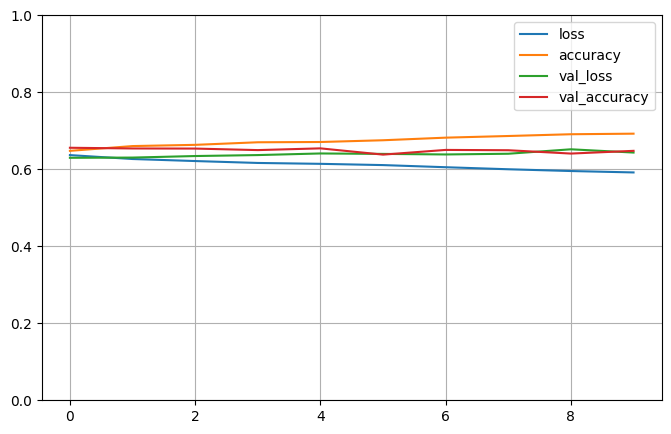

accuracy: 64.79%
Fold 1
Train set ones/size 21638 / 42931
Valid set ones/size 5325 / 10519
BUILD MODEL
COMPILE...
...COMPILED
FIT
Epoch 1/10
1342/1342 [==============================] - 4s 2ms/step - loss: 0.6372 - accuracy: 0.6475 - val_loss: 0.6257 - val_accuracy: 0.6648
Epoch 2/10
1342/1342 [==============================] - 3s 2ms/step - loss: 0.6282 - accuracy: 0.6589 - val_loss: 0.6313 - val_accuracy: 0.6664
Epoch 3/10
1342/1342 [==============================] - 4s 3ms/step - loss: 0.6235 - accuracy: 0.6640 - val_loss: 0.6255 - val_accuracy: 0.6572
Epoch 4/10
1342/1342 [==============================] - 3s 2ms/step - loss: 0.6175 - accuracy: 0.6708 - val_loss: 0.6258 - val_accuracy: 0.6578
Epoch 5/10
1342/1342 [==============================] - 3s 3ms/step - loss: 0.6126 - accuracy: 0.6724 - val_loss: 0.6228 - val_accuracy: 0.6626
Epoch 6/10
1342/1342 [==============================] - 4s 3ms/step - loss: 0.6093 - accuracy: 0.6769 - val_loss: 0.6315 - val_accuracy: 0.6568
Epoch 

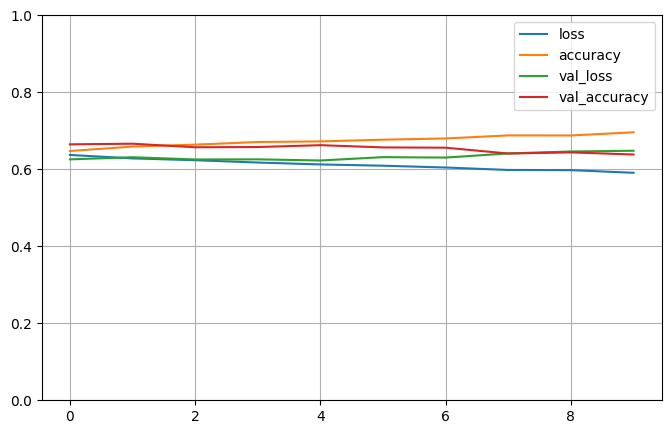

accuracy: 63.84%
Fold 2
Train set ones/size 21208 / 42666
Valid set ones/size 5755 / 10784
BUILD MODEL
COMPILE...
...COMPILED
FIT
Epoch 1/10
1334/1334 [==============================] - 4s 3ms/step - loss: 0.6334 - accuracy: 0.6516 - val_loss: 0.6473 - val_accuracy: 0.6401
Epoch 2/10
1334/1334 [==============================] - 3s 3ms/step - loss: 0.6242 - accuracy: 0.6626 - val_loss: 0.6491 - val_accuracy: 0.6432
Epoch 3/10
1334/1334 [==============================] - 3s 2ms/step - loss: 0.6187 - accuracy: 0.6685 - val_loss: 0.6461 - val_accuracy: 0.6490
Epoch 4/10
1334/1334 [==============================] - 3s 2ms/step - loss: 0.6149 - accuracy: 0.6685 - val_loss: 0.6496 - val_accuracy: 0.6375
Epoch 5/10
1334/1334 [==============================] - 3s 2ms/step - loss: 0.6110 - accuracy: 0.6707 - val_loss: 0.6457 - val_accuracy: 0.6391
Epoch 6/10
1334/1334 [==============================] - 3s 2ms/step - loss: 0.6041 - accuracy: 0.6750 - val_loss: 0.6653 - val_accuracy: 0.6363
Epoch 

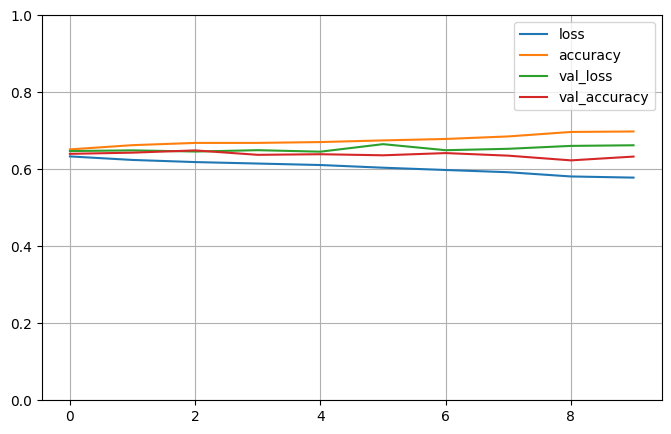

accuracy: 63.30%
Fold 3
Train set ones/size 21740 / 42962
Valid set ones/size 5223 / 10488
BUILD MODEL
COMPILE...
...COMPILED
FIT
Epoch 1/10
1343/1343 [==============================] - 4s 3ms/step - loss: 0.6364 - accuracy: 0.6465 - val_loss: 0.6186 - val_accuracy: 0.6655
Epoch 2/10
1343/1343 [==============================] - 3s 2ms/step - loss: 0.6252 - accuracy: 0.6609 - val_loss: 0.6253 - val_accuracy: 0.6625
Epoch 3/10
1343/1343 [==============================] - 3s 2ms/step - loss: 0.6219 - accuracy: 0.6606 - val_loss: 0.6335 - val_accuracy: 0.6567
Epoch 4/10
1343/1343 [==============================] - 3s 2ms/step - loss: 0.6138 - accuracy: 0.6687 - val_loss: 0.6354 - val_accuracy: 0.6484
Epoch 5/10
1343/1343 [==============================] - 3s 2ms/step - loss: 0.6089 - accuracy: 0.6743 - val_loss: 0.6240 - val_accuracy: 0.6579
Epoch 6/10
1343/1343 [==============================] - 3s 2ms/step - loss: 0.6036 - accuracy: 0.6785 - val_loss: 0.6335 - val_accuracy: 0.6566
Epoch 

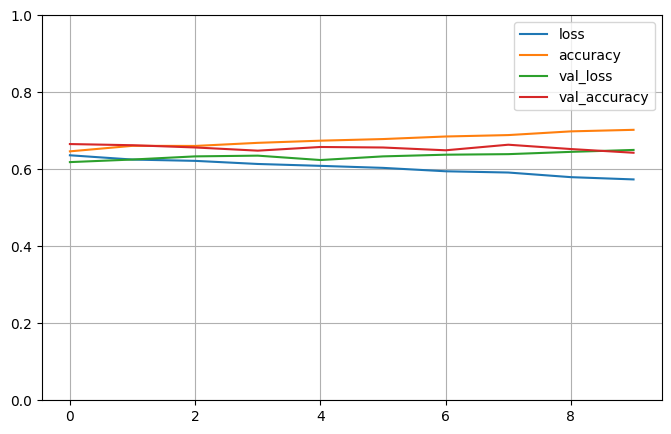

accuracy: 64.29%
Fold 4
Train set ones/size 21824 / 42682
Valid set ones/size 5139 / 10768
BUILD MODEL
COMPILE...
...COMPILED
FIT
Epoch 1/10
1334/1334 [==============================] - 4s 2ms/step - loss: 0.6345 - accuracy: 0.6499 - val_loss: 0.6482 - val_accuracy: 0.6340
Epoch 2/10
1334/1334 [==============================] - 3s 2ms/step - loss: 0.6244 - accuracy: 0.6612 - val_loss: 0.6486 - val_accuracy: 0.6477
Epoch 3/10
1334/1334 [==============================] - 3s 2ms/step - loss: 0.6194 - accuracy: 0.6638 - val_loss: 0.6394 - val_accuracy: 0.6446
Epoch 4/10
1334/1334 [==============================] - 3s 2ms/step - loss: 0.6132 - accuracy: 0.6700 - val_loss: 0.6440 - val_accuracy: 0.6391
Epoch 5/10
1334/1334 [==============================] - 3s 3ms/step - loss: 0.6118 - accuracy: 0.6694 - val_loss: 0.6482 - val_accuracy: 0.6373
Epoch 6/10
1334/1334 [==============================] - 3s 3ms/step - loss: 0.6043 - accuracy: 0.6774 - val_loss: 0.6499 - val_accuracy: 0.6401
Epoch 

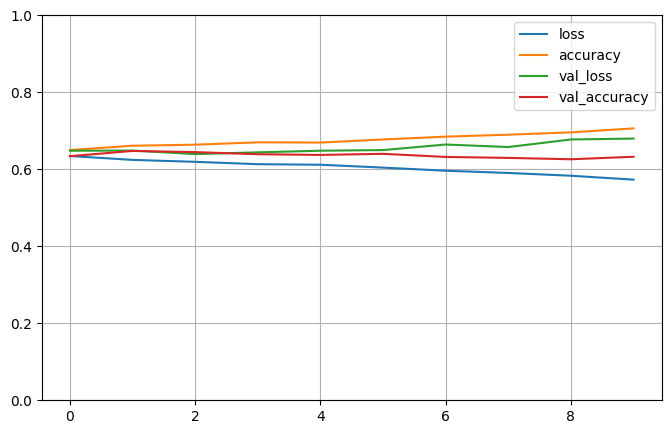

accuracy: 63.25%

Validation core mean 63.89% (+/- 0.59%)
2022-10-11 10:16:24.713892


In [12]:
print(datetime.now())
model=build_model()
print ("Summarize the model")
print(model.summary())  # Print this only once

print ("Cross valiation")
do_cross_validation(splitter,EPOCHS)
print(datetime.now())

# to do
Do train/valid split with respect to genes. 